In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [2]:
lr = 0.0002
batch_size = 128
epochs = 100000

image_dim = 784
Y_dimension = 10
gen_hidden_dim = 256
disc_hidden_dim = 256
z_noise_dim = 100 


def xavier_init(shape):
  return tf.random_normal(shape = shape, stddev= 1./tf.sqrt(shape[0]/2.0))

In [3]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2020-09-16 20:25:12--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.73.82
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.73.82|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz.1’

train-images-idx3-u 100%[===================>]  25.20M  11.9MB/s    in 2.1s    

2020-09-16 20:25:14 (11.9 MB/s) - ‘train-images-idx3-ubyte.gz.1’ saved [26421880/26421880]

--2020-09-16 20:25:14--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.72.23
Connecting to fashion-mnist.s3-website.eu-central-1.ama

In [4]:
!pip install tensorflow==1.12.0
import tensorflow as tf
print(tf.__version__)

1.12.0


In [5]:
!mkdir MNIST_Fashion
!cp *.gz MNIST_Fashion/
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_Fashion/")

mkdir: cannot create directory ‘MNIST_Fashion’: File exists
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_Fashion/train-labels-idx1-ubyte.gz
Extracting MNIST_Fashion/t10k-images-idx3-ubyte.gz
Extracting MNIST_Fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
weights = {
    "disc_H" : tf.Variable(xavier_init([image_dim , disc_hidden_dim])),
    "disc_final": tf.Variable(xavier_init([disc_hidden_dim,1])),
    "gen_H": tf.Variable(xavier_init([z_noise_dim , gen_hidden_dim])),
    "gen_final": tf.Variable(xavier_init([gen_hidden_dim, image_dim]))
}

bias = {
    "disc_H" : tf.Variable(xavier_init([disc_hidden_dim])),
    "disc_final": tf.Variable(xavier_init([1])),
    "gen_H": tf.Variable(xavier_init([gen_hidden_dim])),
    "gen_final": tf.Variable(xavier_init([image_dim]))
}

In [7]:
z_input = tf.placeholder(tf.float32, shape = [None, z_noise_dim], name = "latent_var")
x_input = tf.placeholder(tf.float32, shape = [None, image_dim], name = "real_input")

In [8]:
def Discriminator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["disc_H"]), bias["disc_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["disc_final"]), bias["disc_final"]))
  disc_output = (final_layer)  #It acts as a Regressor to fit the D(G(z)) onto D(X) by reducing Wasserstein Dist, so no SOFTMAX. 
  return disc_output

In [9]:
def Generator(x):
  hidden_layer = tf.nn.relu(tf.add(tf.matmul(x, weights["gen_H"]), bias["gen_H"]))
  final_layer = (tf.add(tf.matmul(hidden_layer, weights["gen_final"]), bias["gen_final"]))
  gen_output = tf.nn.sigmoid(final_layer)
  return gen_output

In [10]:

with tf.name_scope("Generator") as scope:
  output_Gen = Generator(z_input) 
 

with tf.name_scope("Discriminator") as scope:
  real_output_disc = Discriminator(x_input) 
  fake_output_disc = Discriminator(output_Gen)


In [11]:
with tf.name_scope("Discriminator_Loss") as scope:
  Discriminator_Loss = tf.reduce_mean(real_output_disc)-tf.reduce_mean(fake_output_disc)
  
with tf.name_scope("Generator_Loss") as scope:
  Generator_Loss = -tf.reduce_mean(fake_output_disc) # due to max log(D(G(x)))

  # T-board summary
  
  Disc_loss_total = tf.summary.scalar("Disc_Total_loss", Discriminator_Loss)
  Gen_loss_total = tf.summary.scalar("Gen_loss", Generator_Loss)

In [12]:
Generator_var = [weights["gen_H"], weights["gen_final"], bias["gen_H"], bias["gen_final"]]
Discriminator_var = [weights["disc_H"], weights["disc_final"], bias["disc_H"], bias["disc_final"]]

#RMSProp used in paper instead of Adam
with tf.name_scope("Optimizer_Discriminator") as scope: #note the - sign before Disc_Loss as we need to maximise 
  Discriminator_optimize = tf.train.RMSPropOptimizer(learning_rate = lr).minimize(-Discriminator_Loss, var_list = Discriminator_var)

with tf.name_scope("Optimizer_Generator") as scope:
  Generator_optimize = tf.train.RMSPropOptimizer(learning_rate = lr).minimize(Generator_Loss, var_list = Generator_var)
  
# Clipping of the Disc weights, and bias
clip_disc_param = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in Discriminator_var] # Lipschitz continuity, slope of D < 1

In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()

sess.run(init)
writer = tf.summary.FileWriter("./log", sess.graph)

for epoch in range(epochs):
  
  for _ in range(5): #Here the disc is a critic and is used to get the values of the G closer to the real dist, it helps to model the Wasserstein Metric
    x_batch, _ = mnist.train.next_batch(batch_size)

    z_noise = np.random.uniform(-1., 1., size = [batch_size, z_noise_dim])
    _, Disc_loss_epoch, clipping_D = sess.run([Discriminator_optimize, Discriminator_Loss, clip_disc_param], feed_dict = {x_input:x_batch, z_input:z_noise})
  
  
  _, Gen_loss_epoch = sess.run([Generator_optimize, Generator_Loss], feed_dict = {z_input:z_noise})  

  summary_Disc_loss = sess.run(Disc_loss_total, feed_dict = {x_input:x_batch, z_input:z_noise})
  writer.add_summary(summary_Disc_loss, epoch)

  summary_Gen_loss = sess.run(Gen_loss_total, feed_dict = {z_input:z_noise})
  writer.add_summary(summary_Gen_loss, epoch)
  
  if epoch % 2000 == 0:
    print("Steps: {0}: Generator Loss: {1}, Discriminator Loss:{2}".format(epoch, Gen_loss_epoch, Disc_loss_epoch))

Steps: 0: Generator Loss: -0.02737734094262123, Discriminator Loss:-0.013206612318754196
Steps: 2000: Generator Loss: -0.09622707962989807, Discriminator Loss:0.08439800143241882
Steps: 4000: Generator Loss: 0.008304508402943611, Discriminator Loss:0.026671240106225014
Steps: 6000: Generator Loss: -0.04518773406744003, Discriminator Loss:0.0668940320611
Steps: 8000: Generator Loss: -0.010799786075949669, Discriminator Loss:0.02747872844338417
Steps: 10000: Generator Loss: 0.059008896350860596, Discriminator Loss:0.03634044900536537
Steps: 12000: Generator Loss: 0.021310225129127502, Discriminator Loss:0.02316785231232643
Steps: 14000: Generator Loss: -0.022513242438435555, Discriminator Loss:0.01878467947244644
Steps: 16000: Generator Loss: 0.017307370901107788, Discriminator Loss:0.018819423392415047
Steps: 18000: Generator Loss: 0.0357101708650589, Discriminator Loss:0.021646084263920784
Steps: 20000: Generator Loss: 0.014322222210466862, Discriminator Loss:0.01953313872218132
Steps:

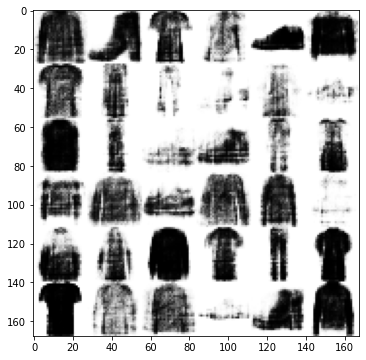

In [14]:
n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  #Noise input
  z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
  # Generate image from noise
  g = sess.run(output_Gen, feed_dict = {z_input:z_noise})
  # Reverse colors for better display
  g=-1*(g-1)
  for j in range(n):
    #Draw the generated digits
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28, 28])
    
plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()

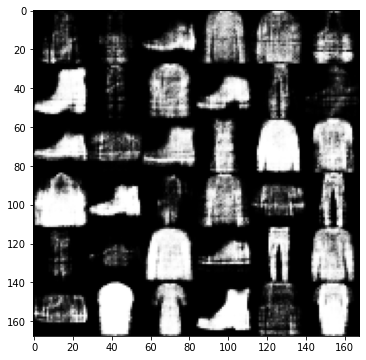

In [15]:
n = 6
canvas = np.empty((28*n, 28*n))
for i in range(n):
  #Noise input
  z_noise = np.random.uniform(-1.,1., size = [batch_size, z_noise_dim])
  # Generate image from noise
  g = sess.run(output_Gen, feed_dict = {z_input:z_noise})
  for j in range(n):
    #Draw the generated digits
    canvas[i*28:(i+1)*28, j*28:(j+1)*28] = g[j].reshape([28, 28])
    
plt.figure(figsize = (n,n))
plt.imshow(canvas, origin = "upper", cmap = "gray")
plt.show()